# ETF 資產配置策略

## 大綱

- ### 介紹
- ### 資料集、標的與資料處理
- ### 投組建立與回測

# 1. 介紹(投資靈感)

### 方法論
基於投資組合分散的目的，投資於股票型、債券型及黃金ETF。

**權重配置**
- 0050：0.5。
- 00679B：0.25。
- 00635U：0.25。
- 由於00679B的上市期間晚於0050，故在上市前的部位會以0050取代；00635U的上市期間晚於0050及00679B，故在上市前的部位會以0050及00679B取代。

**再平衡**
- 月初。

**滑價**
- 使用預設模型。

### 參考資料
Trading Evolved: Anyone can Build Killer Trading Strategies in Python pp. 135-154

# 2. 資料集與標的

## Imports & Settings

In [1]:
import os
import pandas as pd
import tejapi
os.environ['TEJAPI_KEY'] = 'your key'
os.environ['TEJAPI_BASE'] = 'https://api.tej.com.tw'

import zipline
from zipline import run_algorithm
from zipline.api import (order_target_percent,
                         symbol,
                         schedule_function,
                         date_rules,
                         time_rules,
                         set_benchmark,
                         get_datetime)
from zipline.utils.calendar_utils import get_calendar 

from matplotlib import pyplot as plt
import pandas as pd
import empyrical as ep
from logbook import Logger, StderrHandler, INFO

import warnings
warnings.filterwarnings('ignore')

In [2]:
# calendar
calendar_name='TEJ'

# bundle_name
bundle_name = 'tquant'

# set date
start='2005-01-01'
end='2023-08-25'


# 由文字型態轉為Timestamp，供回測使用
tz = 'UTC'
start_dt, end_dt = pd.Timestamp(start, tz = tz), pd.Timestamp(end, tz = tz)

# 設定os.environ['mdate'] = start+' '+end，供ingest bundle使用
os.environ['mdate'] = start+' '+end

pd.set_option('display.max_rows', 80)

# 設定log顯示方式
log_handler = StderrHandler(format_string='[{record.time:%Y-%m-%d %H:%M:%S.%f}]: ' +
                            '{record.level_name}: {record.func_name}: {record.message}',
                            level=INFO)
log_handler.push_application()
log = Logger('Algorithm')

In [3]:
# 取得start當天所有ETF的公司碼
from zipline.sources.TEJ_Api_Data import get_universe
pool = get_universe(start, end, stktp_e=['ETF','Foreign ETF'])

[2024-02-07 03:51:40.139429]: INFO: get_universe_TW: Filters：{'stktp_e': ['ETF', 'Foreign ETF']}


Currently used TEJ API key call quota 579/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 62480747/9223372036854775807 (0.0%)


In [4]:
# 設定os.environ['ticker']=公司碼，供後續ingest bundle用。

os.environ['ticker'] = ' '.join(pool+['IR0001'])

## Ingest

In [5]:
!zipline ingest -b tquant

Merging daily equity files:
Currently used TEJ API key call quota 586/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 63564801/9223372036854775807 (0.0%)


[2024-02-07 03:51:47.167002] INFO: zipline.data.bundles.core: Ingesting tquant.
[2024-02-07 03:52:25.671912] INFO: zipline.data.bundles.core: Ingest tquant successfully.


## 投資標的

In [6]:
# set universe and weight
securities = {
                '0050': 0.5,     # 市值型：元大台灣卓越50證券投資信託基金（臺灣50指數 FTSE TWSE Taiwan 50 Index）
                '00679B': 0.25,  # 債券型：元大美國政府20年期(以上)債券證券投資信託基金（ICE美國政府20+年期債券指數 (ICE U.S.Treasury 20+ Year Bond Index）
                '00635U': 0.25   # 期貨型：元大標普高盛黃金ER指數股票型期貨信託基金（標普高盛黃金超額回報指數 S&P GSCI Gold Excess Return Index）
            }

# 3. 投組建立與回測

[2024-02-07 03:52:26.756536]: INFO: rebalance: 2005-01-03 can trade sec:{'0050'}
[2024-02-07 03:52:26.783831]: INFO: rebalance: 2005-02-01 can trade sec:{'0050'}
[2024-02-07 03:52:26.793956]: INFO: rebalance: 2005-03-01 can trade sec:{'0050'}
[2024-02-07 03:52:26.826951]: INFO: rebalance: 2005-04-01 can trade sec:{'0050'}
[2024-02-07 03:52:26.846946]: INFO: rebalance: 2005-05-03 can trade sec:{'0050'}
[2024-02-07 03:52:26.867254]: INFO: earn_dividends: Equity(0 [0050]), cash_dividend amount: 1.8499999999999999, pay_date: 2005-06-13, div_owed: 388801.55
[2024-02-07 03:52:26.877328]: INFO: rebalance: 2005-06-01 can trade sec:{'0050'}
[2024-02-07 03:52:26.906870]: INFO: rebalance: 2005-07-01 can trade sec:{'0050'}
[2024-02-07 03:52:26.931361]: INFO: rebalance: 2005-08-01 can trade sec:{'0050'}
[2024-02-07 03:52:26.958551]: INFO: rebalance: 2005-09-02 can trade sec:{'0050'}
[2024-02-07 03:52:26.978907]: INFO: rebalance: 2005-10-03 can trade sec:{'0050'}
[2024-02-07 03:52:27.009567]: INFO: 

[2024-02-07 03:52:29.124272]: INFO: rebalance: 2012-06-01 can trade sec:{'0050'}
[2024-02-07 03:52:29.154480]: INFO: rebalance: 2012-07-02 can trade sec:{'0050'}
[2024-02-07 03:52:29.174788]: INFO: rebalance: 2012-08-01 can trade sec:{'0050'}
[2024-02-07 03:52:29.205660]: INFO: rebalance: 2012-09-03 can trade sec:{'0050'}
[2024-02-07 03:52:29.226117]: INFO: rebalance: 2012-10-01 can trade sec:{'0050'}
[2024-02-07 03:52:29.246675]: INFO: earn_dividends: Equity(0 [0050]), cash_dividend amount: 1.8499999999999999, pay_date: 2012-11-27, div_owed: 522523.24999999994
[2024-02-07 03:52:29.256850]: INFO: rebalance: 2012-11-01 can trade sec:{'0050'}
[2024-02-07 03:52:29.285175]: INFO: rebalance: 2012-12-03 can trade sec:{'0050'}
[2024-02-07 03:52:29.307549]: INFO: rebalance: 2013-01-02 can trade sec:{'0050'}
[2024-02-07 03:52:29.339760]: INFO: rebalance: 2013-02-01 can trade sec:{'0050'}
[2024-02-07 03:52:29.356327]: INFO: rebalance: 2013-03-01 can trade sec:{'0050'}
[2024-02-07 03:52:29.379093

[2024-02-07 03:52:32.287735]: INFO: rebalance: 2018-07-02 can trade sec:{'00679B', '00635U', '0050'}
[2024-02-07 03:52:32.337987]: INFO: earn_dividends: Equity(0 [0050]), cash_dividend amount: 0.7, pay_date: 2018-08-27, div_owed: 106929.2
[2024-02-07 03:52:32.366010]: INFO: rebalance: 2018-08-01 can trade sec:{'00679B', '00635U', '0050'}
[2024-02-07 03:52:32.408537]: INFO: earn_dividends: Equity(72 [00679B]), cash_dividend amount: 0.27, pay_date: 2018-09-26, div_owed: 45226.62
[2024-02-07 03:52:32.439756]: INFO: rebalance: 2018-09-03 can trade sec:{'00679B', '00635U', '0050'}
[2024-02-07 03:52:32.499496]: INFO: rebalance: 2018-10-01 can trade sec:{'00679B', '00635U', '0050'}
[2024-02-07 03:52:32.577395]: INFO: rebalance: 2018-11-01 can trade sec:{'00679B', '00635U', '0050'}
[2024-02-07 03:52:32.626333]: INFO: earn_dividends: Equity(72 [00679B]), cash_dividend amount: 0.245, pay_date: 2018-12-25, div_owed: 40632.76
[2024-02-07 03:52:32.650396]: INFO: rebalance: 2018-12-03 can trade sec:

[2024-02-07 03:52:35.386366]: INFO: rebalance: 2022-06-01 can trade sec:{'00679B', '00635U', '0050'}
[2024-02-07 03:52:35.455194]: INFO: rebalance: 2022-07-01 can trade sec:{'00679B', '00635U', '0050'}
[2024-02-07 03:52:35.490206]: INFO: earn_dividends: Equity(0 [0050]), cash_dividend amount: 1.8, pay_date: 2022-08-19, div_owed: 271686.60000000003
[2024-02-07 03:52:35.523608]: INFO: rebalance: 2022-08-01 can trade sec:{'00679B', '00635U', '0050'}
[2024-02-07 03:52:35.555463]: INFO: earn_dividends: Equity(72 [00679B]), cash_dividend amount: 0.29, pay_date: 2022-09-12, div_owed: 70662.84999999999
[2024-02-07 03:52:35.586762]: INFO: rebalance: 2022-09-01 can trade sec:{'00679B', '00635U', '0050'}
[2024-02-07 03:52:35.655817]: INFO: rebalance: 2022-10-03 can trade sec:{'00679B', '00635U', '0050'}
[2024-02-07 03:52:35.703679]: INFO: rebalance: 2022-11-01 can trade sec:{'00679B', '00635U', '0050'}
[2024-02-07 03:52:35.741257]: INFO: earn_dividends: Equity(72 [00679B]), cash_dividend amount: 

Ready to analyze result.


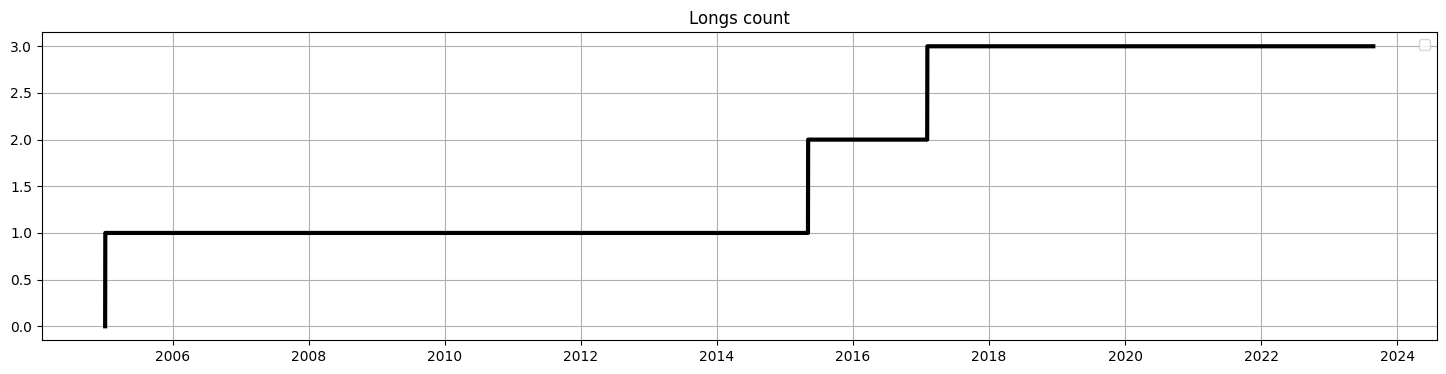

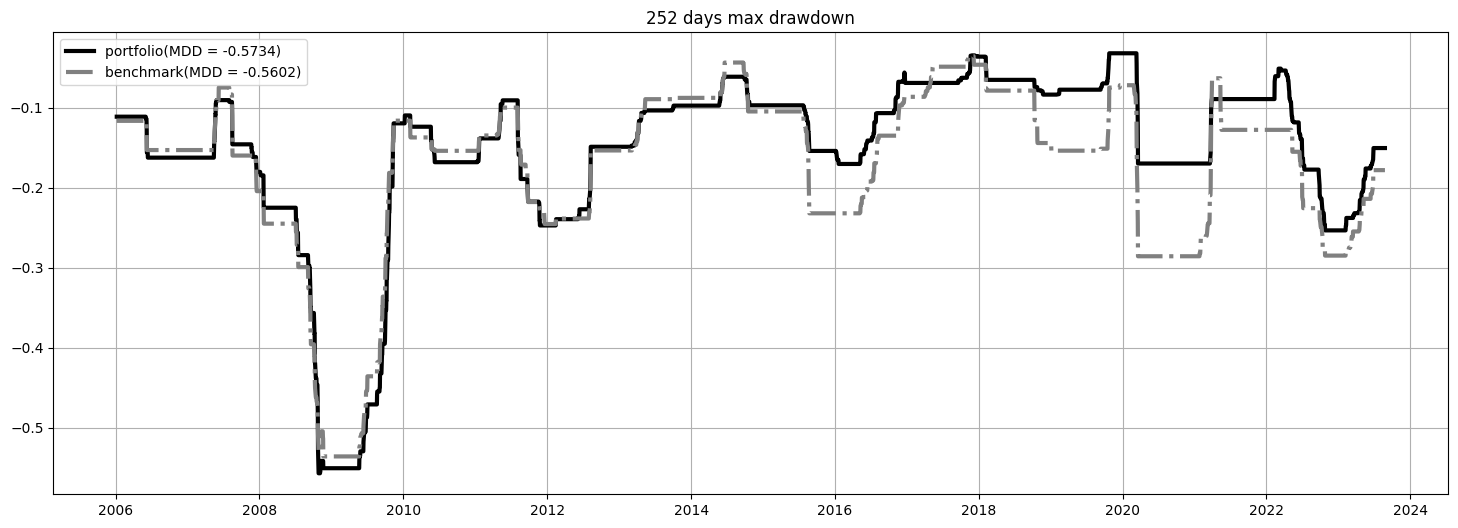

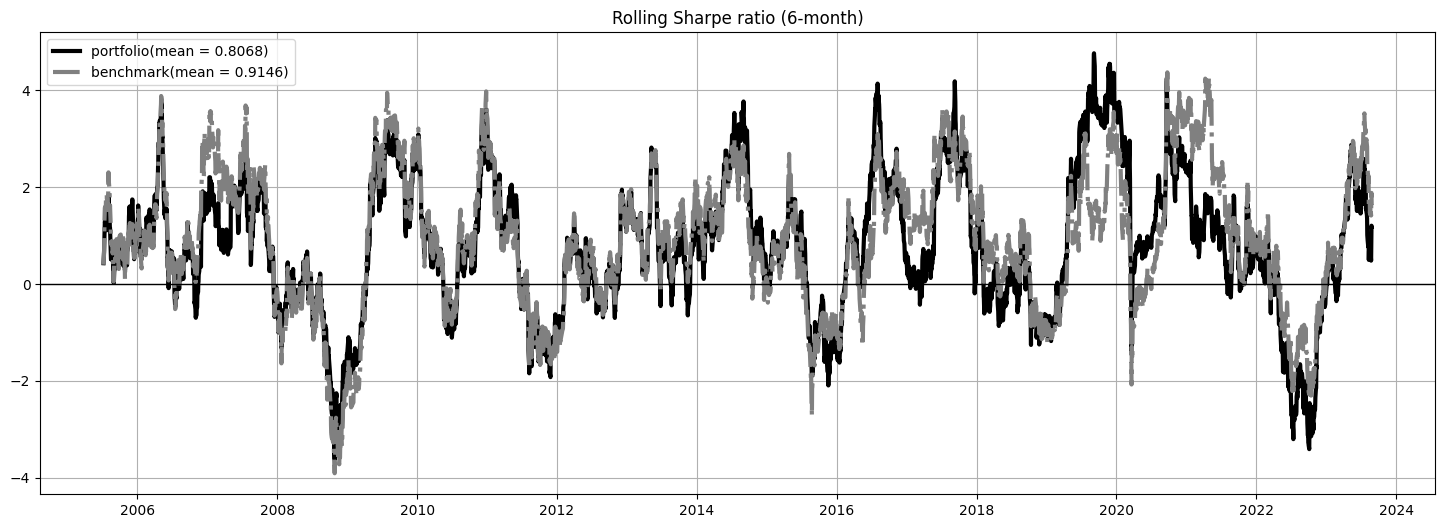

In [7]:
%matplotlib inline
def initialize(context):
    # Securities and target weights
    context.securities = securities   
    set_benchmark(symbol('IR0001'))
        
    # Schedule rebalance for once a month
    schedule_function(rebalance,
                      date_rules.month_start(),
                      time_rules.market_open())
    
def rebalance(context, data):
    
    can_trade_sec = []
    
#     Loop through the securities    
    for sec, weight in context.securities.items():
        try:
            sym = symbol(sec)
            # Check if we can trade
            if data.can_trade(sym):
                # construct a can trade list
                can_trade_sec.append(sec)
        except:
            log.info('"' + str(sec) + '"' + ' does not exist on bundle: ' + get_datetime().strftime('%Y-%m-%d'))
        
    total_weight = sum(value for key, value in context.securities.items() if key in can_trade_sec)

    if len(can_trade_sec)>0:
        log.info(get_datetime().strftime('%Y-%m-%d') + ' can trade sec:' + str(set(can_trade_sec)))
    
#     Start trading
    for sec in can_trade_sec:
        sym = symbol(sec)
        weight = context.securities[sec]
        # Reset the weight
        order_target_percent(sym, weight * ((1-total_weight) * 1 / total_weight + 1))    
            
def analyze(context, perf):
    
#     longs_count
    fig, ax = plt.subplots(figsize=(18, 4))
    
    ax.plot(perf['longs_count'], 
            linestyle='-', 
            color='black',
            linewidth=3.0)

    ax.set_title(label='Longs count')
    ax.legend()
    ax.grid(True)
        
#     MDD
    fig, ax = plt.subplots(figsize=(18, 6))
 
    window = 252
 
    mdd = ep.stats.roll_max_drawdown(perf['returns'],
                                     window=window)
    mdd_x = mdd.sort_index().round(10).idxmin()
    mdd_y = mdd.min()

    ax.plot(mdd, 
        label='portfolio(MDD = {})'.format(round(ep.max_drawdown(perf['returns']),4)), 
        linestyle='-', 
        color='black',
        linewidth=3.0)
    
   
    benchmark_mdd = ep.stats.roll_max_drawdown(perf['benchmark_return'],
                                               window=window)
    benchmark_mdd_x = benchmark_mdd.sort_index().round(10).idxmin()
    benchmark_mdd_y = benchmark_mdd.min()

    ax.plot(benchmark_mdd, 
        label='benchmark(MDD = {})'.format(round(ep.max_drawdown(perf['benchmark_return']),4)), 
        linestyle='-.', 
        color='gray',
        linewidth=3.0)
        
    ax.set_title(label='{} days max drawdown'.format(window))
    ax.legend()
    ax.grid(True)
    
#     roll_sharpe_ratio
    fig, ax = plt.subplots(figsize=(18, 6))
    
    rolling_sharpe = ep.stats.roll_sharpe_ratio(perf['returns'],
                                                window=21 * 6)
    
    portfolio_mean_sharpe_ratio = rolling_sharpe.mean()
    
    
    benchmark_rolling_sharpe = ep.stats.roll_sharpe_ratio(perf['benchmark_return'],
                                                          window=21 * 6)
    
    benchmark_mean_sharpe_ratio = benchmark_rolling_sharpe.mean()
    
    ax.plot(rolling_sharpe, 
            label='portfolio(mean = {})'.format(round(portfolio_mean_sharpe_ratio,4)), 
            linestyle='-', 
            color='black',
            linewidth=3.0)
    
    ax.plot(benchmark_rolling_sharpe, 
        label='benchmark(mean = {})'.format(round(benchmark_mean_sharpe_ratio,4)), 
        linestyle='-.', 
        color='gray',
        linewidth=3.0)

    ax.axhline(0.0, color="black", linestyle="-", lw=1)
    
    ax.set_title(label='Rolling Sharpe ratio (6-month)')
    ax.legend()
    ax.grid(True)

# Fire off backtest
result = run_algorithm(start=start_dt,            
                       end=end_dt,                          
                       initialize=initialize,
                       analyze=analyze,
                       capital_base=1e7,
                       data_frequency='daily',
                       bundle=bundle_name,
                       trading_calendar=get_calendar(calendar_name))

print("Ready to analyze result.")

## Pyfolio

In [8]:
import pyfolio as pf
from pyfolio.utils import extract_rets_pos_txn_from_zipline
from pyfolio.txn import make_transaction_frame
import empyrical

In [9]:
# Extract returns, positions, transactions and leverage from the backtest data structure returned by zipline.
# TradingAlgorithm.run().
returns, positions, transactions = extract_rets_pos_txn_from_zipline(result)

In [10]:
benchmark_rets = result['benchmark_return']

In [11]:
# The data must have a **tz-aware DateTimeIndex set to UTC**, with a time of **0:00**, 
# otherwise some plots won't be able to be generated.
returns.index = returns.index.tz_localize(None).tz_localize('UTC')
positions.index = positions.index.tz_localize(None).tz_localize('UTC')
transactions.index = transactions.index.tz_localize(None).tz_localize('UTC')
benchmark_rets.index = benchmark_rets.index.tz_localize(None).tz_localize('UTC')

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,57.34,2007-10-11,2008-11-20,2011-01-19,822
1,25.32,2022-01-17,2022-10-25,NaT,NaN
2,24.70,2011-01-28,2011-11-25,2013-05-16,565
3,17.01,2015-04-27,2016-01-20,2016-07-11,297
4,16.95,2020-03-09,2020-03-19,2020-06-10,65


Stress Events,mean,min,max
Lehman,-0.29%,-4.75%,6.99%
US downgrade/European Debt Crisis,-0.33%,-5.88%,3.50%
Fukushima,0.18%,-1.72%,2.17%
EZB IR Event,0.13%,-0.82%,2.49%
Aug07,-0.02%,-4.52%,4.53%
Mar08,-0.04%,-2.93%,4.22%
Sept08,-0.69%,-4.75%,6.99%
2009Q1,0.03%,-6.35%,3.81%
2009Q2,0.61%,-3.92%,7.00%
Flash Crash,-0.97%,-2.75%,0.87%


Top 10 long positions of all time,max
sid,
0050,100.05%
00635U,37.81%
00679B,28.28%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
0050,100.05%
00635U,37.81%
00679B,28.28%


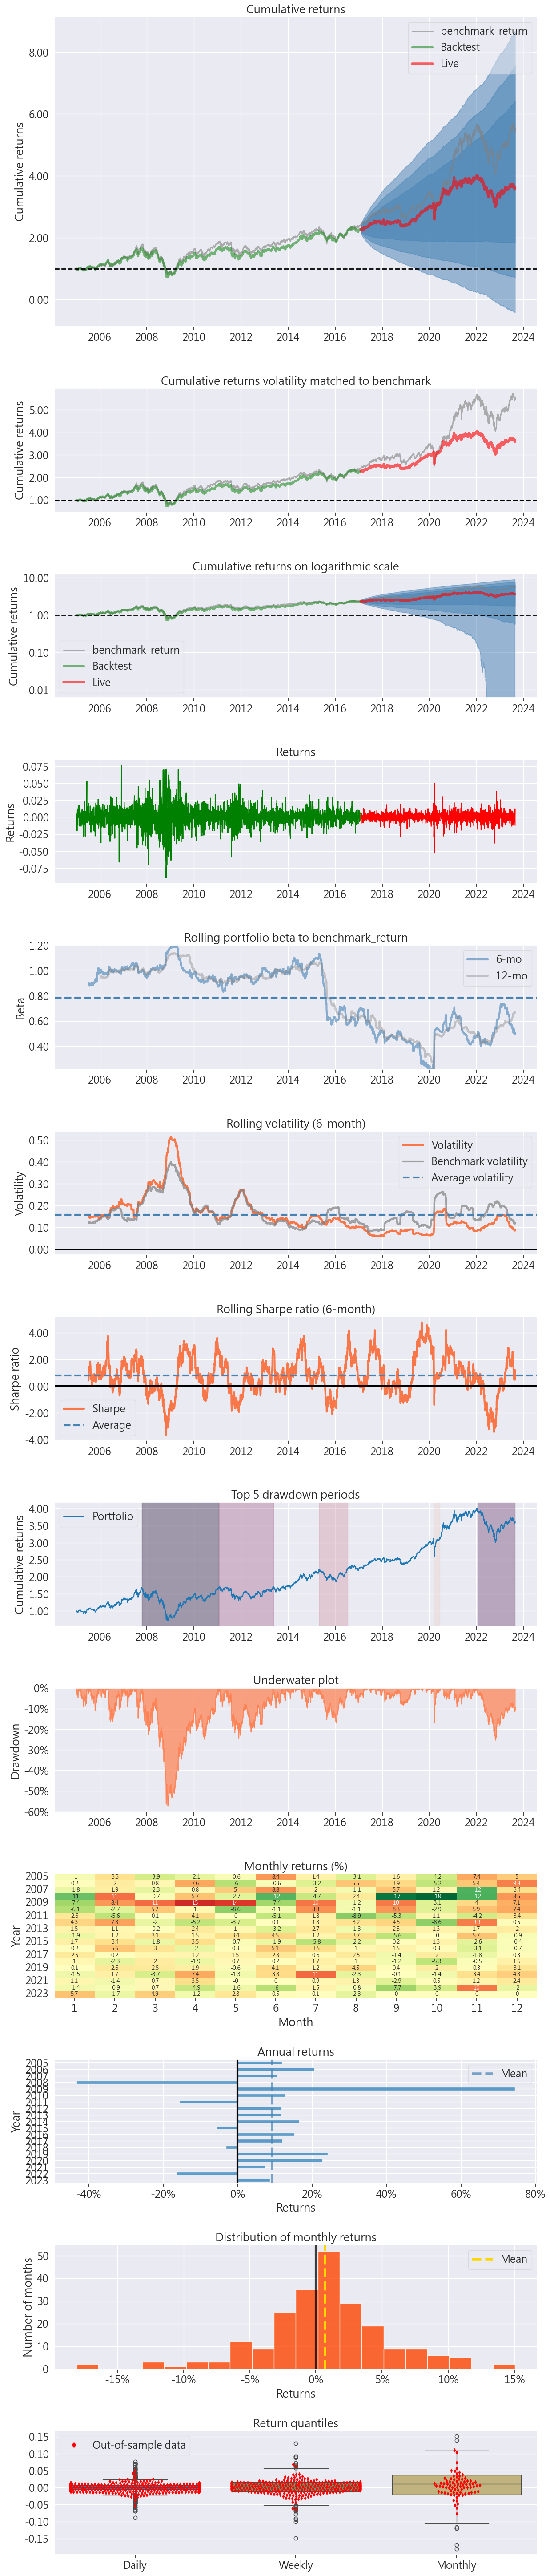

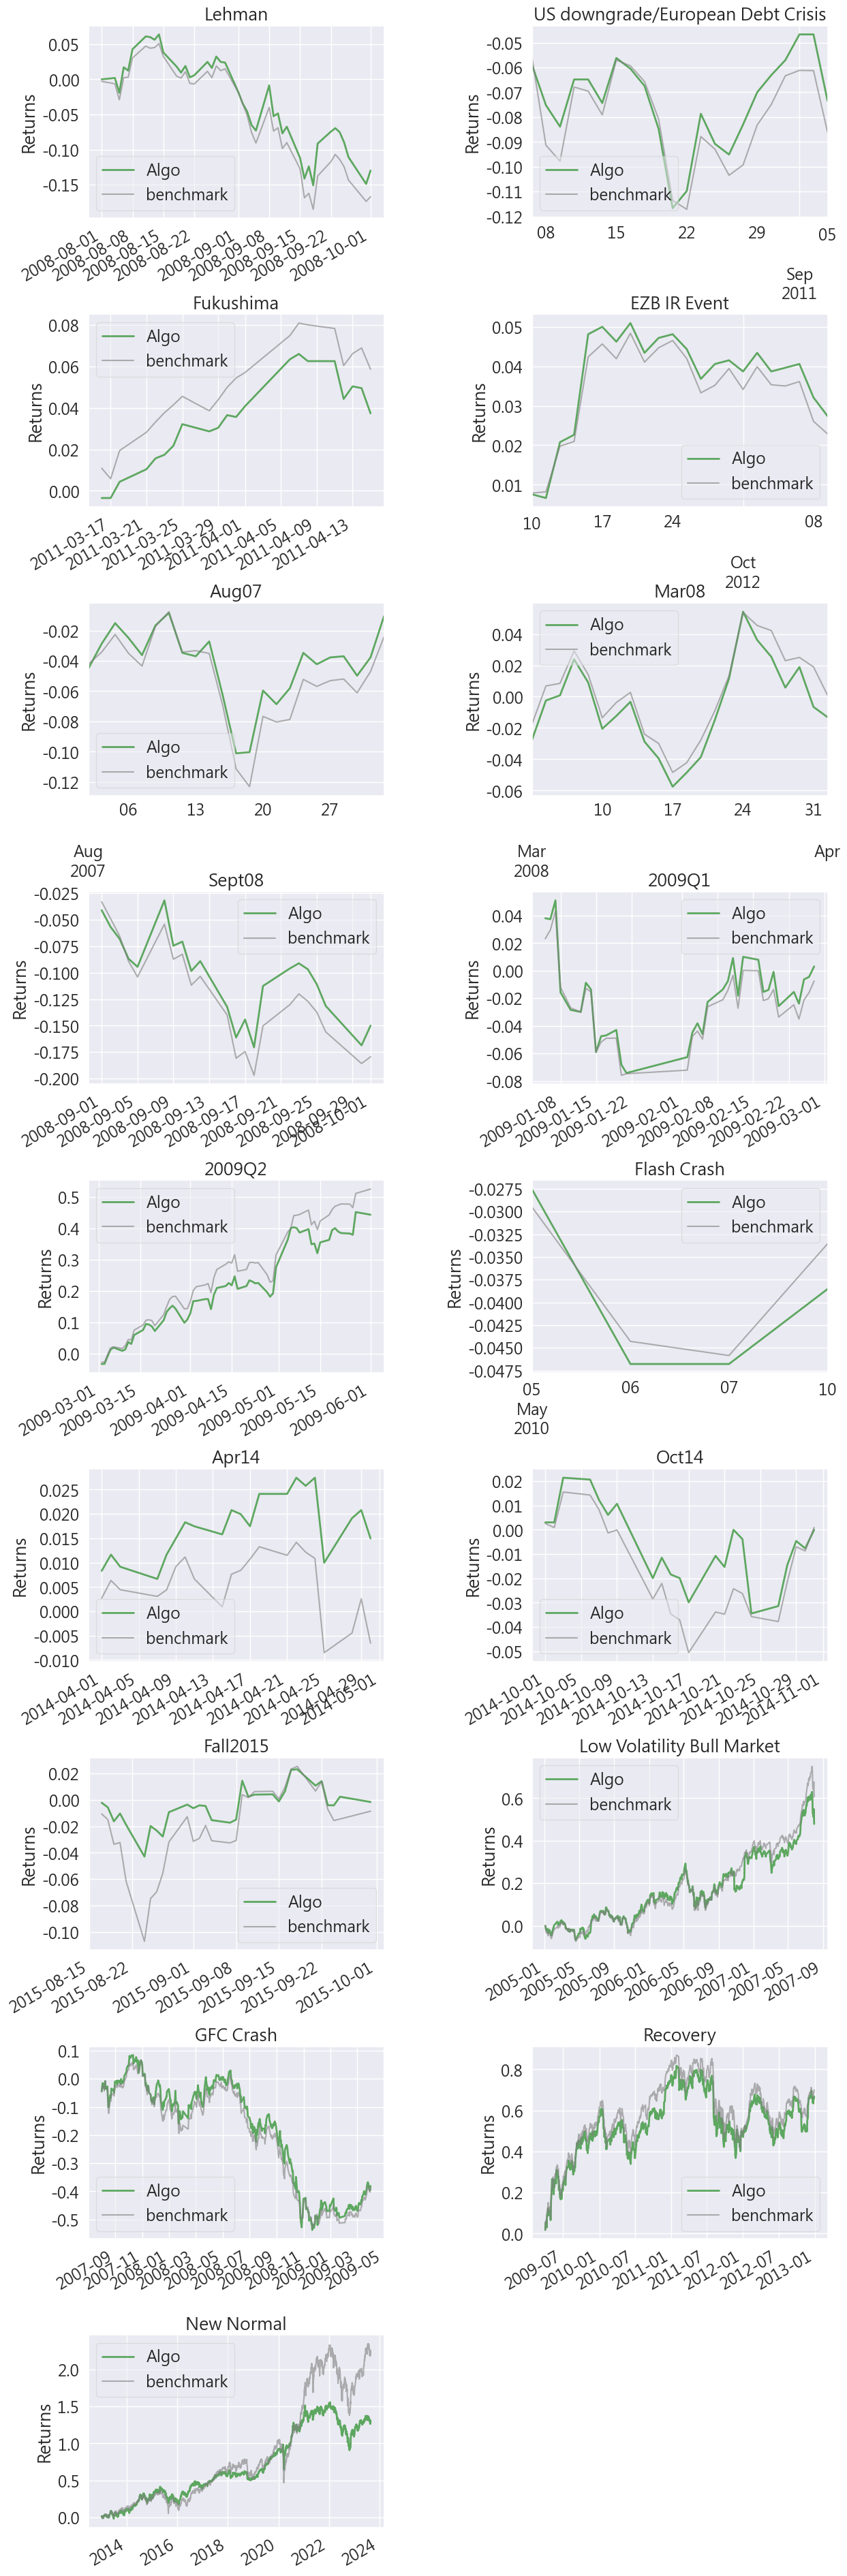

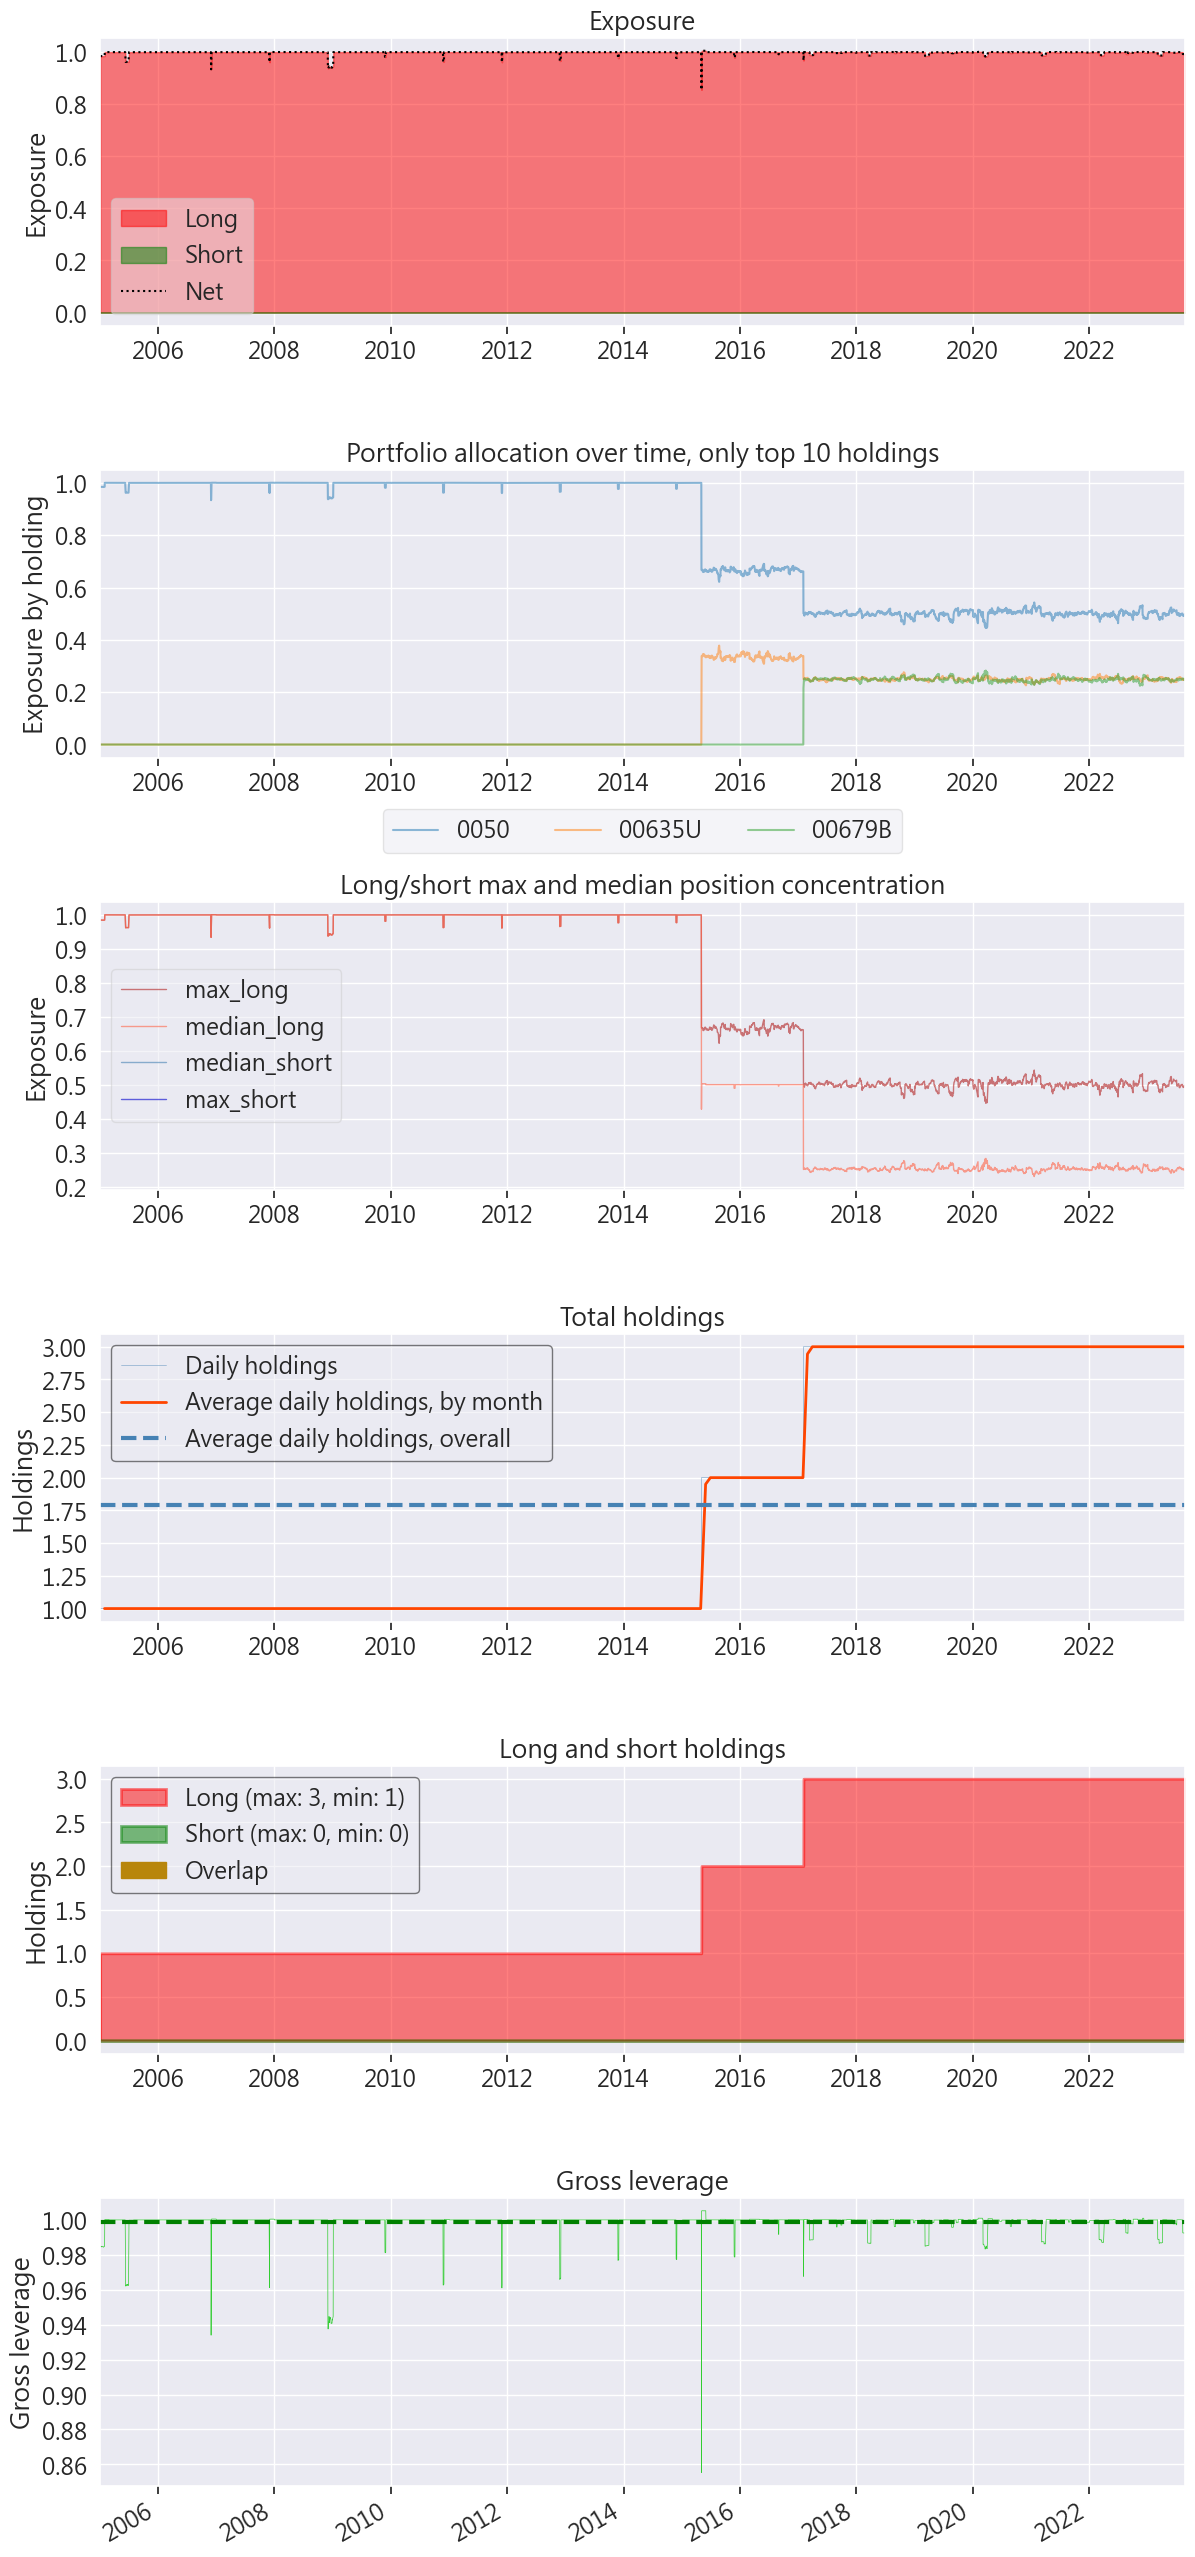

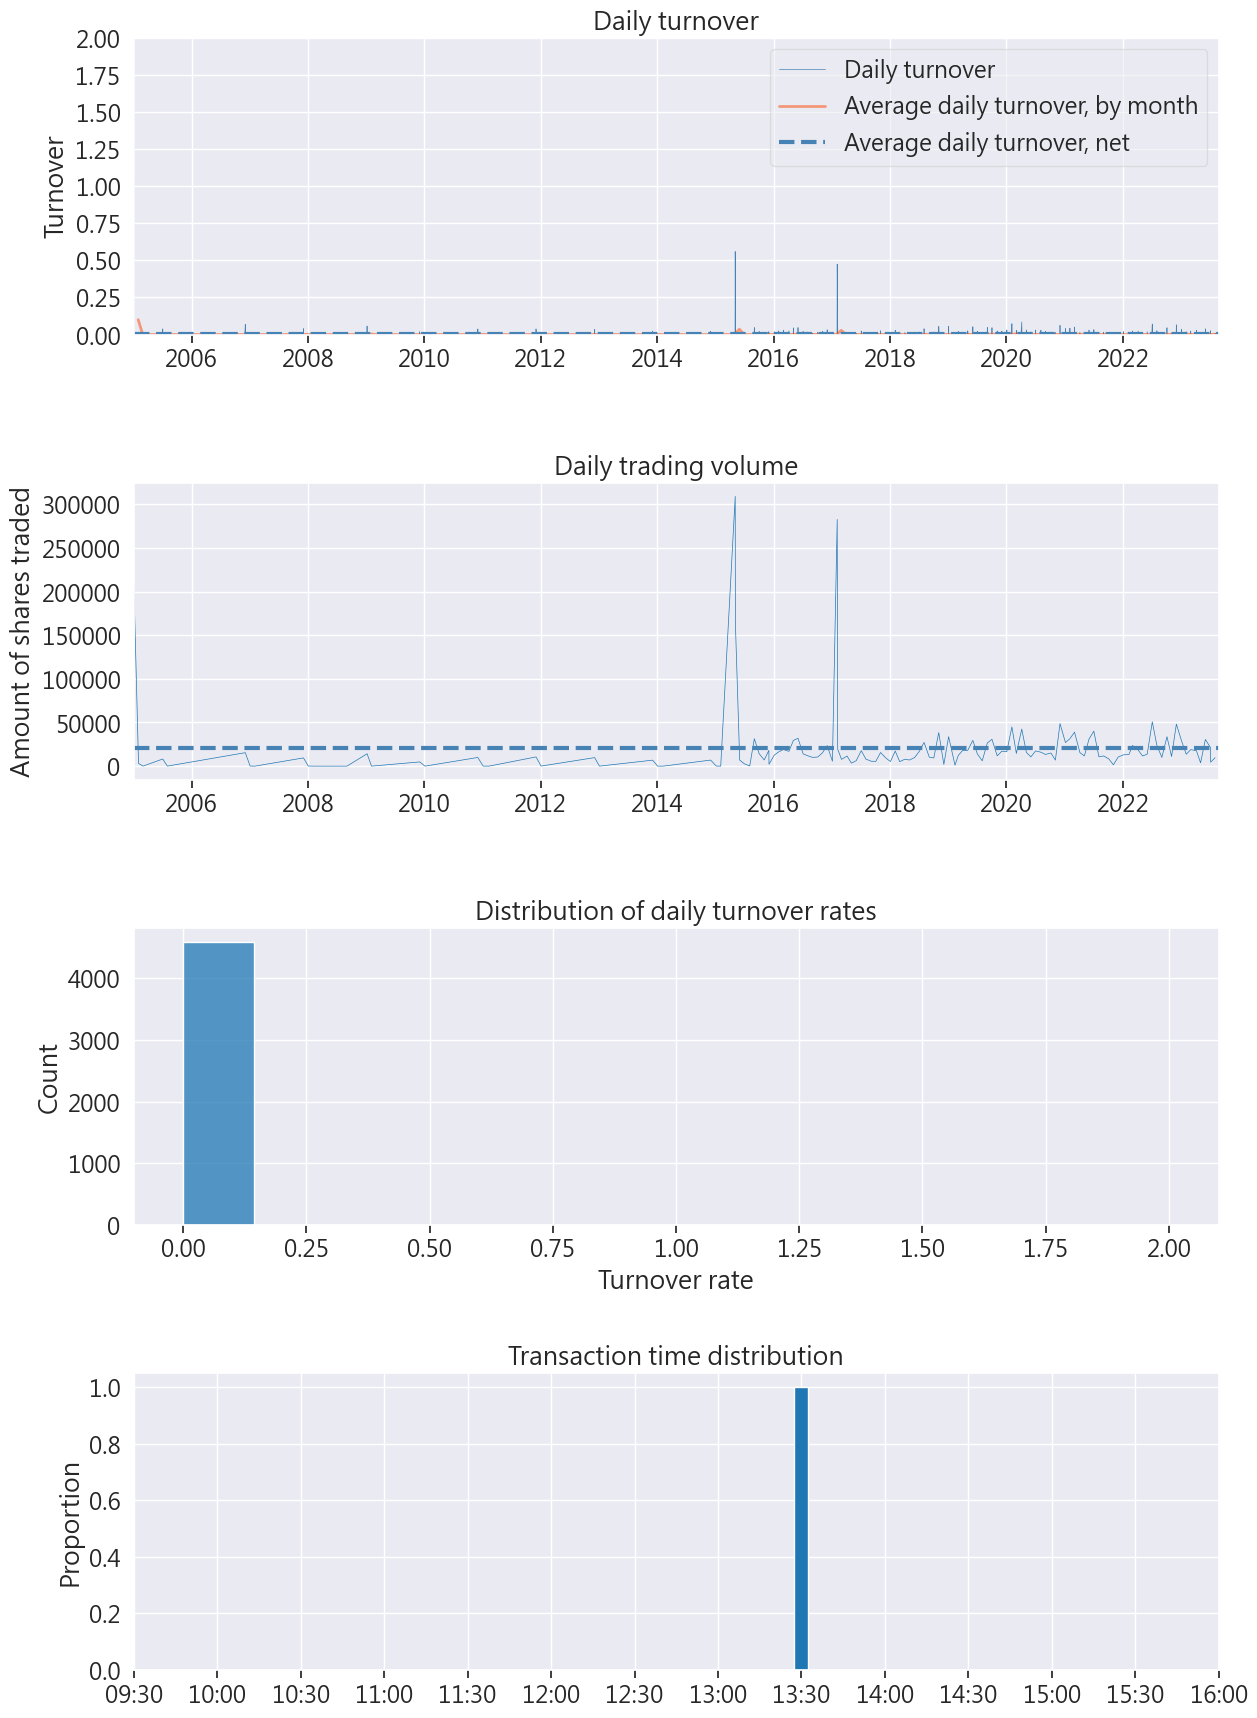

In [12]:
pf.tears.create_full_tear_sheet(returns=returns,
                                positions=positions,
                                transactions=transactions,
                                benchmark_rets=benchmark_rets,
                                live_start_date='20170202'
                               )